# Data preprocessing
### 1 Data cleaning

Remove HTML tags, URLs, punctuation, etc.
Lower case processing.
Word segmentation.
Remove stop words.
Part-of-speech tagging and lemmatization. (part-of-speech sensitive lemmatization)

### 2 Exploratory analysis

Statistical label category distribution (stressful / not-stressful).
Statistical text length distribution (histogram visualization).
Generate a word cloud to intuitively display the high-frequency words of the cleaned text.
Compare the difference in text length distribution before and after cleaning (visual comparison chart).

### 3 Training-validation set division

Divide the training set into training set and validation set at 80/20 to keep the label distribution balanced.
Generate and save three data set files: clean_train.csv, clean_valid.csv, clean_test.csv.

In [1]:
#  ------------ Import necessary libraries  ------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag



# === Read the dataset ===
# Load Dreaddit training and test sets
train_path = "CORPORA/REDDIT/DREADDIT/dreaddit-train.csv"
test_path = "CORPORA/REDDIT/DREADDIT/dreaddit-test.csv"

train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)

In [2]:
test_raw

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.800000,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.000000,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.000000,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.500000,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.800000,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,24271,ptsd,7vavh4,"(0, 5)",i have horrible vivid nightmares every night. ...,1,1.000000,1.517790e+09,7,4.597368,...,1.0000,1.2000,1.0,1.76956,1.46522,1.84112,0.79,15,4.589333,-0.075000
711,2212,relationships,7oeyuc,"[70, 75]",Also I can't think about both of them without ...,1,0.571429,1.515192e+09,0,1.452083,...,1.0000,1.1818,1.0,1.67960,1.51429,1.83530,0.50,7,2.833889,0.189286
712,27951,relationships,7ssxec,"(35, 40)","Furthermore, I told him before we got really s...",1,0.600000,1.516849e+09,3,3.956447,...,1.0000,1.0000,1.0,1.71367,1.50909,1.85501,0.72,10,5.709053,-0.044444
713,1164,assistance,90bila,"[8, 13]",Here's the link to my amazon wish list where t...,0,0.600000,1.532048e+09,18,0.236814,...,1.5000,1.0000,1.0,1.65132,1.53913,1.90766,0.74,2,2.365294,0.090000


In [3]:
# Keep only the 'text' and 'label' columns
train_df = train_raw[['text', 'label']].copy()
test_df = test_raw[['text', 'label']].copy()

print("Number of training samples:", train_df.shape[0])
print("Number of test samples:", test_df.shape[0])
print("\nFirst 3 rows of training data:\n", train_df.head(3))

Number of training samples: 2838
Number of test samples: 715

First 3 rows of training data:
                                                 text  label
0  He said he had not felt that way before, sugge...      1
1  Hey there r/assistance, Not sure if this is th...      0
2  My mom then hit me with the newspaper and it s...      1


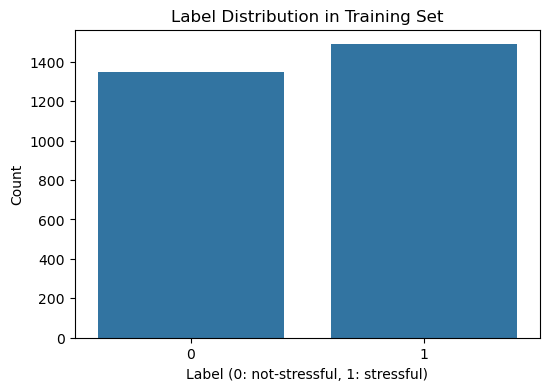

In [4]:
#  ------------Exploratory Data Analysis  ------------
# Visualize the label distribution in the training set
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='label')
plt.title("Label Distribution in Training Set")
plt.xlabel("Label (0: not-stressful, 1: stressful)")
plt.ylabel("Count")
plt.show()

In [5]:
#  ------------ Text Cleaning and Preprocessing  ------------
# Download stopword list and WordNet resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to map Penn Treebank tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    """
    Map Penn Treebank POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # fallback to noun

# Load stop words and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function to clean the text data
def clean_text(text):
    """
    Full cleaning process:Remove HTML tags and URLs, Remove non-alphabetic characters, Lowercase text, 
    Tokenize and remove stop words, POS tagging and lemmatization
    """
    text = re.sub(r'<.*?>', '', str(text))  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Lowercase

    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    pos_tags = pos_tag(tokens)  # POS tagging

    # Lemmatization with accurate POS
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]
    return ' '.join(lemmatized_tokens)

# Apply the cleaning function to training and test data
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Display a few cleaned examples for sanity check
print("\nExample of cleaned text:\n", train_df[['text', 'clean_text']].head(3))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Example of cleaned text:
                                                 text  \
0  He said he had not felt that way before, sugge...   
1  Hey there r/assistance, Not sure if this is th...   
2  My mom then hit me with the newspaper and it s...   

                                          clean_text  
0  say felt way suggeted go rest trigger ahead yo...  
1  hey rassistance sure right place post go im cu...  
2  mom hit newspaper shock would know dont like p...  


In [6]:
train_df

,text,label,clean_text
0,"He said he had not felt that way before, sugge...",1,say felt way suggeted go rest trigger ahead yo...
1,"Hey there r/assistance, Not sure if this is th...",0,hey rassistance sure right place post go im cu...
2,My mom then hit me with the newspaper and it s...,1,mom hit newspaper shock would know dont like p...
3,"until i met my new boyfriend, he is amazing, h...",1,meet new boyfriend amaze kind sweet good stude...
4,October is Domestic Violence Awareness Month a...,1,october domestic violence awareness month dome...
...,...,...,...
2833,"* Her, a week ago: Precious, how are you? (I i...",0,week ago precious ignore jan happy year precio...
2834,I don't have the ability to cope with it anymo...,1,dont ability cope anymore im try lot thing tri...
2835,In case this is the first time you're reading ...,0,case first time youre read post look people wi...
2836,Do you find this normal? They have a good rela...,0,find normal good relationship main problem see...


In [7]:
#  ------------ Split the training data into train and validation sets (80/20)  ------------
# Stratify ensures the label distribution is preserved
train_final, valid_final = train_test_split(
    train_df[['clean_text', 'label']],
    test_size=0.2,
    random_state=42,
    stratify=train_df['label']
)

print("\nSize of training set after split:", train_final.shape)
print("Size of validation set after split:", valid_final.shape)

# === Save cleaned datasets for future use ===
# Save cleaned training, validation, and test sets to CSV files
train_final.to_csv("clean_train.csv", index=False)
valid_final.to_csv("clean_valid.csv", index=False)
test_df[['clean_text', 'label']].to_csv("clean_test.csv", index=False)

print("\nCleaned datasets saved successfully.")


Size of training set after split: (2270, 2)
Size of validation set after split: (568, 2)

Cleaned datasets saved successfully.


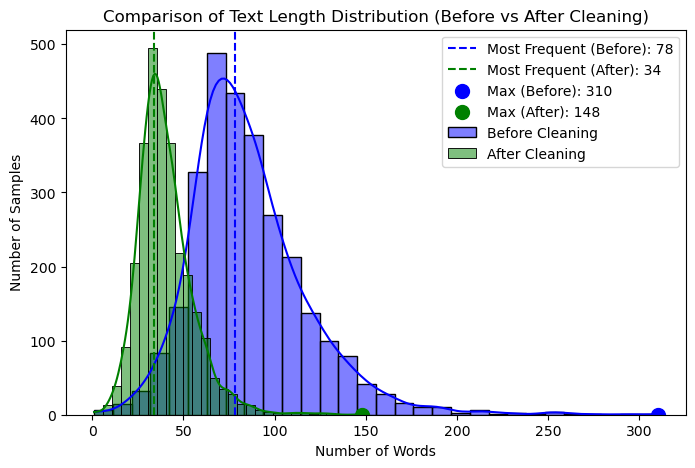

In [8]:
#  ------------ Visualize the distribution of text lengths before and after cleaning in the same plot, with annotations  ------------
# Compute the number of words before and after cleaning
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['clean_text_length'] = train_df['clean_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))

# Plot original text length distribution
sns.histplot(train_df['text_length'], bins=30, kde=True, color='blue', label='Before Cleaning', alpha=0.5)
# Plot cleaned text length distribution
sns.histplot(train_df['clean_text_length'], bins=30, kde=True, color='green', label='After Cleaning', alpha=0.5)

# Calculate most frequent text lengths (mode)
mode_before = train_df['text_length'].mode()[0]
mode_after = train_df['clean_text_length'].mode()[0]

# Calculate maximum text lengths
max_before = train_df['text_length'].max()
max_after = train_df['clean_text_length'].max()

# Annotate mode (most frequent)
plt.axvline(mode_before, color='blue', linestyle='--', label=f"Most Frequent (Before): {mode_before}")
plt.axvline(mode_after, color='green', linestyle='--', label=f"Most Frequent (After): {mode_after}")

# Annotate maximum length
plt.scatter(max_before, 0, color='blue', marker='o', s=100, label=f"Max (Before): {max_before}")
plt.scatter(max_after, 0, color='green', marker='o', s=100, label=f"Max (After): {max_after}")

plt.title("Comparison of Text Length Distribution (Before vs After Cleaning)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()



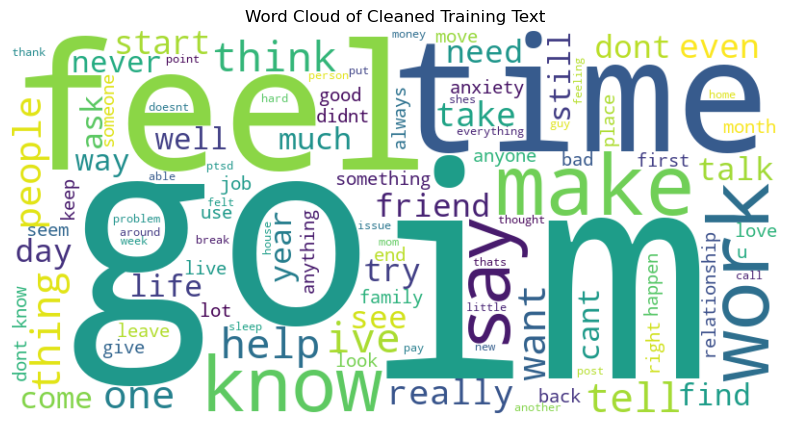

In [9]:
#  ------------ Generate word cloud visualization for high-frequency words  ------------
from wordcloud import WordCloud

# Concatenate all cleaned text into a single string
all_text = ' '.join(train_df['clean_text'].dropna().tolist())

# Create and configure the word cloud object
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=100,  # show top 100 words
                      contour_width=1,
                      contour_color='steelblue').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Training Text")
plt.show()


### TFIDF + SVM

In [10]:
# ----------------Re-import pandas and read the cleaned datasets ---------
import pandas as pd

# Read cleaned training, validation, and test sets
clean_train = pd.read_csv("clean_train.csv")
clean_valid = pd.read_csv("clean_valid.csv")
clean_test = pd.read_csv("clean_test.csv")

# Display the first few rows of each to confirm successful loading
print("First 3 rows of clean_train:")
print(clean_train.head(3))

print("\nFirst 3 rows of clean_valid:")
print(clean_valid.head(3))

print("\nFirst 3 rows of clean_test:")
print(clean_test.head(3))

First 3 rows of clean_train:
                                          clean_text  label
0  get child support well financially without alt...      1
1  xb hey everyone hurricane florence occur less ...      1
2  woke day later intubate paralyzed didnt know l...      0

First 3 rows of clean_valid:
                                          clean_text  label
0  hi everyone thank advance reading move family ...      1
1  anxious wait room full cry baby kid clue reall...      1
2  ok title say sister try set friend couple mont...      0

First 3 rows of clean_test:
                                          clean_text  label
0  like want problem take long ask friend help le...      0
1  man front desk title hr customer service repre...      0
2  wed save much money new housrits expensive cit...      1


In [11]:
# *-------------------- TF-IDF Feature Extraction ----------
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for unigrams
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit on the training set and transform train/valid/test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(clean_train['clean_text'])
X_valid_tfidf = tfidf_vectorizer.transform(clean_valid['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(clean_test['clean_text'])

print("\nTF-IDF features generated successfully.")
print("Shape of training TF-IDF matrix:", X_train_tfidf.shape)
print("Shape of validation TF-IDF matrix:", X_valid_tfidf.shape)
print("Shape of test TF-IDF matrix:", X_test_tfidf.shape)


TF-IDF features generated successfully.
Shape of training TF-IDF matrix: (2270, 5000)
Shape of validation TF-IDF matrix: (568, 5000)
Shape of test TF-IDF matrix: (715, 5000)


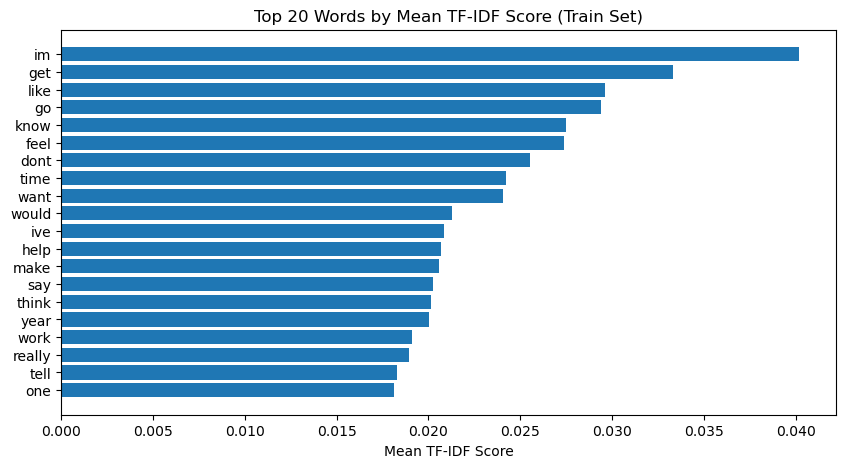

In [12]:
# ---------   Visualize top 20 high-frequency words in training data
import numpy as np
import matplotlib.pyplot as plt

feature_names = tfidf_vectorizer.get_feature_names_out()
mean_tfidf = np.array(X_train_tfidf.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[::-1][:20]

top_words = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

plt.figure(figsize=(10, 5))
plt.barh(top_words[::-1], top_scores[::-1])
plt.xlabel("Mean TF-IDF Score")
plt.title("Top 20 Words by Mean TF-IDF Score (Train Set)")
plt.show()

1. Reddit corpus is colloquial and fragmented:
These words appear very frequently in the Reddit community, but they may not bring practical analysis value.

2. TF-IDF is calculated based on "term frequency-inverse document frequency", but does not fully understand the context: For example: words such as like, get, go appear a lot in Reddit and are also scattered in various posts, so they "look" highly distinguishable (high TF-IDF), but they may not be semantically helpful.

TF-IDF is essentially a bag-of-words model and cannot understand the semantics between words.

In [13]:
# ------------- SVM model with TFIDF training & validation
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prepare target labels
y_train = clean_train['label']
y_valid = clean_valid['label']
y_test = clean_test['label']

# Initialize and train SVM
svm_tfidf = LinearSVC(random_state=42)
svm_tfidf.fit(X_train_tfidf, y_train)

# Predict on validation set
y_valid_pred = svm_tfidf.predict(X_valid_tfidf)

# Evaluate validation set
print("\n=== Validation Set Performance (SVM + TF-IDF) ===")
print(classification_report(y_valid, y_valid_pred))




=== Validation Set Performance (SVM + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       270
           1       0.74      0.73      0.74       298

    accuracy                           0.73       568
   macro avg       0.73      0.73      0.73       568
weighted avg       0.73      0.73      0.73       568



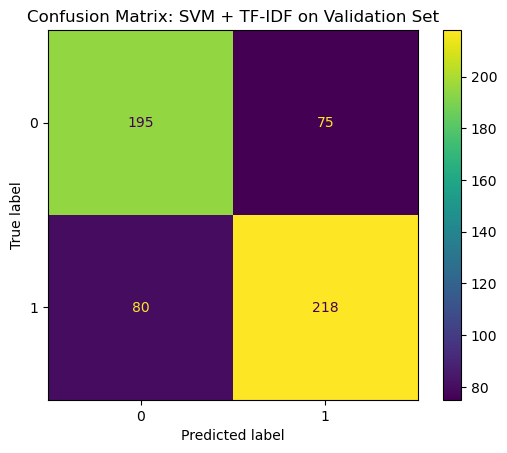

In [14]:
# Visualize confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix: SVM + TF-IDF on Validation Set")
plt.show()

In [15]:
# ------------ Test set evaluation 
y_test_pred = svm_tfidf.predict(X_test_tfidf)
print("\n=== Test Set Performance (SVM + TF-IDF) ===")
print(classification_report(y_test, y_test_pred))


=== Test Set Performance (SVM + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       346
           1       0.72      0.76      0.74       369

    accuracy                           0.72       715
   macro avg       0.72      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



### Random Forest (RF) + TF-IDF

In [20]:
# Load cleaned data for TF-IDF features
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clean_train = pd.read_csv("clean_train.csv")
clean_valid = pd.read_csv("clean_valid.csv")
clean_test = pd.read_csv("clean_test.csv")

# TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(clean_train['clean_text'])
X_valid_tfidf = tfidf_vectorizer.transform(clean_valid['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(clean_test['clean_text'])

# Train Random Forest on TF-IDF
y_train = clean_train['label']
y_valid = clean_valid['label']
y_test = clean_test['label']

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)

# Evaluate on test set
y_test_pred_tfidf = rf_tfidf.predict(X_test_tfidf)
print("\n=== Test Set Performance (Random Forest + TF-IDF) ===")
print(classification_report(y_test, y_test_pred_tfidf, digits=2))



=== Test Set Performance (Random Forest + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.80      0.56      0.66       346
           1       0.68      0.87      0.76       369

    accuracy                           0.72       715
   macro avg       0.74      0.72      0.71       715
weighted avg       0.74      0.72      0.71       715



### BiLSTM + GloVe Initialization

In [22]:
# -------   Load Cleaned Data & Build Vocab-------   
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Load cleaned datasets
clean_train = pd.read_csv("clean_train.csv")
clean_valid = pd.read_csv("clean_valid.csv")
clean_test = pd.read_csv("clean_test.csv")

# Build vocab manually
word_counter = Counter()
for text in clean_train['clean_text']:
    word_counter.update(text.split())

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, _) in enumerate(word_counter.most_common(), start=2):
    vocab[word] = idx

def tokenize(text):
    return text.split()

def text_to_ids(text, vocab, max_len=100):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return ids[:max_len]




In [23]:
# -------   Load GloVe and Build Embedding Matrix-------   
def load_glove_vectors(glove_file_path, embedding_dim=100):
    word_vectors = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.asarray(parts[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

glove_vectors = load_glove_vectors("glove.6B.100d.txt", embedding_dim=100)
print("Loaded GloVe vectors. Example:", list(glove_vectors.items())[:1])

vocab_size = len(vocab)
embedding_dim = 100
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))
for word, idx in vocab.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)




Loaded GloVe vectors. Example: [('the', array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2

In [24]:
# -------   Dataset & DataLoader -------   
class RedditDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        token_ids = text_to_ids(self.texts[idx], self.vocab, self.max_len)
        return torch.tensor(token_ids), torch.tensor(self.labels[idx])

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts_padded, torch.tensor(labels)

train_dataset = RedditDataset(clean_train['clean_text'].tolist(), clean_train['label'].tolist(), vocab)
valid_dataset = RedditDataset(clean_valid['clean_text'].tolist(), clean_valid['label'].tolist(), vocab)
test_dataset = RedditDataset(clean_test['clean_text'].tolist(), clean_test['label'].tolist(), vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)




In [25]:
#-------   BiLSTM Model with Max Pooling and Deeper Classifier-------   
class BiLSTMMaxPoolClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix):
        super(BiLSTMMaxPoolClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = True

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, text):
        embedded = self.embedding(text)
        output, _ = self.lstm(embedded)
        pooled, _ = torch.max(output, dim=1)
        return self.classifier(pooled)

hidden_dim = 128
output_dim = 2
pad_idx = vocab["<pad>"]
model = BiLSTMMaxPoolClassifier(len(vocab), embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix)


In [26]:
# -------   Training & Evaluation -------   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, iterator):
    model.train()
    total_loss = 0
    for texts, labels in iterator:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in iterator:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            preds = predictions.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(iterator), correct / total

for epoch in range(5):
    train_loss = train(model, train_loader)
    valid_loss, valid_acc = evaluate(model, valid_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Valid Loss={valid_loss:.4f}, Valid Acc={valid_acc:.4f}")


Epoch 1: Train Loss=0.6463, Valid Loss=0.5784, Valid Acc=0.6813
Epoch 2: Train Loss=0.5279, Valid Loss=0.5566, Valid Acc=0.6937
Epoch 3: Train Loss=0.4351, Valid Loss=0.4919, Valid Acc=0.7570
Epoch 4: Train Loss=0.3307, Valid Loss=0.5270, Valid Acc=0.7729
Epoch 5: Train Loss=0.2182, Valid Loss=0.5486, Valid Acc=0.7623


In [27]:
# -------   Test Set Performance (Classification Report) -------   
from sklearn.metrics import classification_report

def get_preds_and_labels(model, iterator):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            predictions = model(texts)
            preds = predictions.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

y_test_true, y_test_pred = get_preds_and_labels(model, test_loader)
print("\n=== Test Set Performance (BiLSTM + Max Pooling + Deeper Classifier) ===")
print(classification_report(y_test_true, y_test_pred, digits=2))



=== Test Set Performance (BiLSTM + Max Pooling + Deeper Classifier) ===
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       346
           1       0.74      0.69      0.72       369

    accuracy                           0.72       715
   macro avg       0.72      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



### BERT

In [ ]:
# Load Cleaned Data
import pandas as pd

clean_train = pd.read_csv("clean_train.csv")
clean_valid = pd.read_csv("clean_valid.csv")
clean_test = pd.read_csv("clean_test.csv")


In [ ]:
# Load pretrained BERT tokenizer & model
from transformers import AutoTokenizer, AutoModel
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using DistilBERT (lighter, faster)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)


In [ ]:
# Function to get sentence embeddings from BERT
def get_bert_embeddings(texts, tokenizer, model, batch_size=32, max_length=128):
    """
    Given a list of texts, compute the [CLS] token embeddings from BERT.
    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()  # Take [CLS] token embedding
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)


In [ ]:
# Generate sentence embeddings
X_train_bert = get_bert_embeddings(clean_train['clean_text'].tolist(), tokenizer, bert_model)
X_valid_bert = get_bert_embeddings(clean_valid['clean_text'].tolist(), tokenizer, bert_model)
X_test_bert = get_bert_embeddings(clean_test['clean_text'].tolist(), tokenizer, bert_model)

y_train = clean_train['label']
y_valid = clean_valid['label']
y_test = clean_test['label']


In [ ]:
from sklearn.svm import SVC

# Initialize a SVM classifier
clf_svm = SVC(kernel='linear', C=1, random_state=42)
clf_svm.fit(X_train_bert, y_train)

# Predict labels for the test set using the trained SVM
y_test_pred_svm = clf_svm.predict(X_test_bert)

# Print the classification report (precision, recall, f1-score) for each class
from sklearn.metrics import classification_report
print("\n=== Test Set Performance (BERT Embeddings + SVM) ===")
print(classification_report(y_test, y_test_pred_svm, digits=2))



=== Test Set Performance (BERT Embeddings + SVM) ===
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       346
           1       0.69      0.72      0.70       369

    accuracy                           0.69       715
   macro avg       0.69      0.69      0.69       715
weighted avg       0.69      0.69      0.69       715



### Hugging Face mental-roberta-base

In [33]:
# Loading data & preprocessing
import pandas as pd
from datasets import Dataset

# Loading the cleaned Reddit dataset
train_df = pd.read_csv("clean_train.csv")
valid_df = pd.read_csv("clean_valid.csv")
test_df = pd.read_csv("clean_test.csv")

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

In [34]:
# Load the pre-trained tokenizer for the mental-roberta-base model
from transformers import AutoTokenizer
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")

# Define a tokenization function for the dataset
def tokenize(batch):
    """
    Tokenize each example in the dataset batch.
    - batch["clean_text"]: list of text samples to be tokenized
    - truncation: cuts text to max_length if needed
    - padding: ensures all sequences in the batch have the same length (max_length)
    - max_length: 128 tokens (fixed for all samples)
    """
    return tokenizer(batch["clean_text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the training, validation, and test sets
train_dataset = train_dataset.map(tokenize, batched=True)
valid_dataset = valid_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Remove the original text column as it's no longer needed after tokenization
train_dataset = train_dataset.remove_columns(["clean_text"])
valid_dataset = valid_dataset.remove_columns(["clean_text"])
test_dataset = test_dataset.remove_columns(["clean_text"])

# Rename the label column to 'labels' that required by Hugging Face Trainer API
train_dataset = train_dataset.rename_column("label", "labels")
valid_dataset = valid_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

# Set dataset format to PyTorch tensors for compatibility with Trainer
train_dataset.set_format("torch")
valid_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/2270 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

In [35]:
#Load the pre-trained mental-roberta-base model with a classification head
from transformers import AutoModelForSequenceClassification

# Load the pre-trained RoBERTa-based model.
# Since doing binary classification set num_labels=2.
model = AutoModelForSequenceClassification.from_pretrained("mental/mental-roberta-base", num_labels=2)

# Set up training arguments
from transformers import TrainingArguments, Trainer

# Initialize TrainingArguments with basic training configuration.
training_args = TrainingArguments(
    output_dir="./results_mental_roberta",  # Directory to save model checkpoints and logs
    do_train=True,                          # Enable training
    do_eval=True,                           # Enable evaluation during training
    learning_rate=2e-5,                     # Common learning rate for fine-tuning transformers
    per_device_train_batch_size=16,         # Batch size for training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    num_train_epochs=3,                     # Number of training epochs
    weight_decay=0.01,                      # Weight decay for regularization
    logging_dir="./logs"                    # Directory to store logs
)

# Define the evaluation metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Compute standard classification metrics (accuracy, precision, recall, f1).
    
    Args:
    - eval_pred: a tuple (logits, labels) from the Trainer
    
    Returns:
    - A dictionary containing the metrics for logging and evaluation.
    """
    logits, labels = eval_pred
    # Convert logits to predicted labels
    predictions = np.argmax(logits, axis=-1)
    # Compute precision, recall, f1-score with macro averaging (equal weight for each class)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    # Compute overall accuracy
    acc = accuracy_score(labels, predictions)
    # Return metrics in a dictionary
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Create a Trainer instance and start fine-tuning
trainer = Trainer(
    model=model,                        # The model to fine-tune
    args=training_args,                 # Training parameters
    train_dataset=train_dataset,        # Dataset for training
    eval_dataset=valid_dataset,         # Dataset for validation
    tokenizer=tokenizer,                # Tokenizer (needed for saving & loading pipeline)
    compute_metrics=compute_metrics     # Function to compute evaluation metrics
)

# Start the training process
trainer.train()

# Evaluate the model on the test dataset
print("\n=== Test Set Evaluation (mental-roberta-base) ===")
# Evaluate the model on the held-out test dataset
metrics = trainer.evaluate(test_dataset)
print(metrics)


# Generate a classification report on the test dataset
from sklearn.metrics import classification_report

# Predict the labels for the test dataset
preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids         
y_pred = np.argmax(preds_output.predictions, axis=1)

# Print detailed classification report
print("\n=== Classification Report on Test Set (mental-roberta-base) ===")
print(classification_report(y_true, y_pred, digits=2))



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_49580\2344193157.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss



=== Test Set Evaluation (mental-roberta-base) ===


{'eval_loss': 0.6018087863922119, 'eval_accuracy': 0.7748251748251749, 'eval_precision': 0.7762974573319401, 'eval_recall': 0.7733759418519041, 'eval_f1': 0.773718610251118, 'eval_runtime': 2.6788, 'eval_samples_per_second': 266.91, 'eval_steps_per_second': 16.799, 'epoch': 3.0}

=== Classification Report on Test Set (mental-roberta-base) ===
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       346
           1       0.76      0.82      0.79       369

    accuracy                           0.77       715
   macro avg       0.78      0.77      0.77       715
weighted avg       0.78      0.77      0.77       715

